# Natural Statistics Cross-linguistic

Caregiver responses to infants touch and point analysis

In [26]:
# import data

import sys
import warnings
import pandas as pd
import numpy as np
sys.path.insert(0, "data_proc")
warnings.filterwarnings('ignore')
import gen_dat
import contingent_extraction
import analytic_proc

----
### ELAN extraction

In [27]:
# corpus_root = "../data/raw_data/touch_point"

# subs = ["10","12","13","14","16","18","1","9","22","25","28","29","30","24","33","35","3","45","46","4","50","51","53","55","56","5","7","84"]

# # "2"

# naming_constant = "_touch_point"

# tier_names = ["Transcript", "Child_Voc", "inf_touch", "inf_point"]

# cols = ['sub', 'onset', 'offset', 'cat', 'tier']

# output_path = "../data"

# outname = "touch_point"

In [28]:
# gen_dat.eaf2csv(corpus_root,cols,subs,tier_names,naming_constant,output_path,outname)

----
#### Pre-processing

In [29]:
# # Load extracted data

# tp_dat = pd.read_csv("../data/touch_point.csv",index_col=0)

In [30]:
# len(tp_dat["sub"].unique())

In [31]:
# # sort and reset index
# tp_dat = tp_dat.sort_values(by=['sub', 'onset']).reset_index(drop=True)

In [32]:
# # assign contingency with window of 3 seconds
# tp_dat = contingent_extraction.assign_contingency_point(tp_dat,3,0)

In [33]:
# # subset to only caregiver utterances and clean transcript
# cg_tp_dat = tp_dat[tp_dat["tier"]=="Transcript"]
# contingent_extraction.create_tp_result(cg_tp_dat)

----
#### Unique word counts

In [34]:
# load cleaned caregiver utterances dataframe
cg_tp_dat = pd.read_csv("../data/tp_dat_cont.csv",index_col=0)

How do the number of responses to infant vocalizations and number of responses to infants' manual behavior compare?

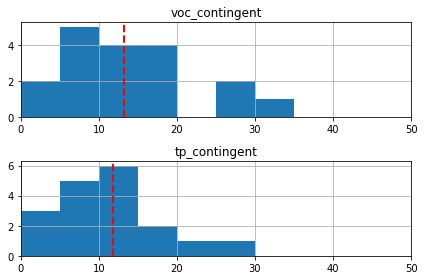

In [35]:
voc_response_count = (cg_tp_dat.groupby(["sub"])
                                .voc_contingent
                                .sum()).reset_index()

manual_response_count = (cg_tp_dat.groupby(["sub"])
                                  .tp_contingent
                                  .sum()).reset_index()

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1)

axes[0].axvline(voc_response_count['voc_contingent'].mean(), color='red', linestyle='dashed', linewidth=2)
axes[0].set_xlim(0,50)
voc_response_count.hist('voc_contingent',bins=10, range=(0,50),ax=axes[0])
axes[1].axvline(manual_response_count['tp_contingent'].mean(), color='red', linestyle='dashed', linewidth=2)
axes[1].set_xlim(0,50)
manual_response_count.hist('tp_contingent',bins=10, range=(0,50), ax=axes[1])
plt.tight_layout()

In [36]:
# drop caregiver utterances which are contingent on infants' vocalizations
cg_tp_dat = cg_tp_dat[cg_tp_dat["voc_contingent"]!=1]

In [37]:
# create seperate contingent and non-contingent utterances for uniqueness calc
c_utterances = cg_tp_dat[cg_tp_dat["tp_contingent"]==1].reset_index(drop=True)
nc_utterances = cg_tp_dat[cg_tp_dat["tp_contingent"]==0].reset_index(drop=True)

In [38]:
# unique word counts

analytic_proc.create_tp_result(c_utterances)
# analytic_proc.create_tp_result(nc_utterances)

In [39]:
c_utterances = pd.read_csv("../data/tp_cont_lexdiv_dat.csv",index_col=0)
nc_utterances = pd.read_csv("../data/tp_noncont_lexdiv_dat.csv",index_col=0)

In [40]:
frames = [c_utterances, nc_utterances]
utterances = pd.concat(frames).reset_index(drop=True)

In [41]:
# MLUw
utterances['cat'] = utterances['cat'].astype(str)

utterances['length'] = utterances['cat'].str.split().apply(len)

# single word utterances
import numpy as np
utterances['single_word'] = np.where(utterances['length']==1,1,0)

----
#### Comparison across contingent and non-contingent

In [42]:
# # are there utterances outside of the middle-10 minutes?

# utterance_sess_min_time_sumstats = (utterances.groupby(["sub"])
#                                               .onset
#                                               .min()).reset_index()

# utterance_sess_max_time_sumstats = (utterances.groupby(["sub"])
#                                               .offset
#                                               .max()).reset_index()

# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(1, 2)

# utterance_sess_min_time_sumstats.hist('onset',ax=axes[0])
# utterance_sess_max_time_sumstats.hist('offset', ax=axes[1])

In [43]:
# exclude utterances outside of the middle-10 minutes
utterances = utterances[(utterances["onset"]>600) & (utterances["onset"]<1200)]

In [44]:
utterance_lexdiv_sumstats = (utterances.groupby(["sub","tp_contingent"])
                                       .uniqueness
                                       .sum()).reset_index()

utterance_mlu_sumstats = (utterances.groupby(["sub","tp_contingent"])
                                  .length
                                  .mean()).reset_index()

utterance_swu_sumstats = (utterances.groupby(["sub","tp_contingent"])
                                  .single_word
                                  .mean()).reset_index()

In [45]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [47]:
%%R 

means <- aggregate(uniqueness ~  tp_contingent, utterance_lexdiv_sumstats, FUN = function(x) {round(mean(x), digits=2)})

means

  tp_contingent uniqueness
1             0      76.00
2             1      28.94


R[write to console]: Saving 11.3 x 6.67 in image



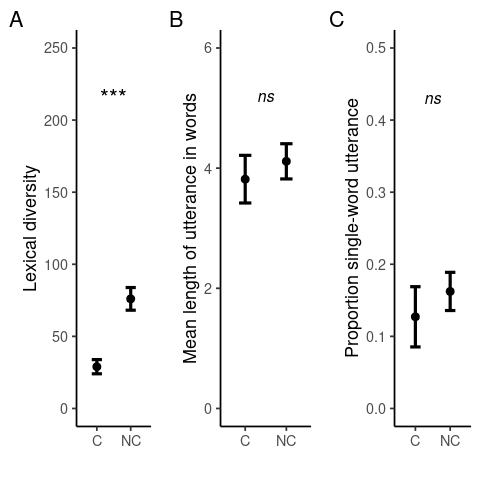

In [68]:
%%R -i utterance_lexdiv_sumstats -i utterance_mlu_sumstats -i utterance_swu_sumstats

library("ggplot2")
library("gridExtra")

utterance_lexdiv_sumstats$tp_contingent <- as.factor(utterance_lexdiv_sumstats$tp_contingent)

means <- aggregate(uniqueness ~  tp_contingent, utterance_lexdiv_sumstats, FUN = function(x) {round(mean(x), digits=2)})

lab1 <- "***"
lab23 <- "ns"

p1 <- ggplot(utterance_lexdiv_sumstats, aes(x=rev(tp_contingent), y=uniqueness)) + 
    theme_classic(base_size = 18) +
#     geom_boxplot(size = 1.5) +
    stat_summary(fun.y=mean, geom="point", shape=19, size=3.5) +
    stat_summary(fun.data = mean_se, geom = "errorbar", size=1.5, width = .3) +
    labs(tag = "A") +
#     stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..),
#                  width = .75, linetype = "dashed") +
#     geom_text(data = means, aes(label = uniqueness, y = uniqueness + 10)) +
    annotate("text", x = 1.5, label = lab1, y = 216, size=8) +
    scale_x_discrete(labels=c("0" = "C", "1" = "NC")) +
    ylim(0, 250) +
    ylab("Lexical diversity") +
    xlab("")

utterance_mlu_sumstats$tp_contingent <- as.factor(utterance_mlu_sumstats$tp_contingent)

means <- aggregate(length ~  tp_contingent, utterance_mlu_sumstats, FUN = function(x) {round(mean(x), digits=2)})

p2 <- ggplot(utterance_mlu_sumstats, aes(x=rev(tp_contingent), y=length)) + 
    theme_classic(base_size = 18) +
#     geom_boxplot(size = 1.5) +
    stat_summary(fun.y=mean, geom="point", shape=19, size=3.5) +
    stat_summary(fun.data = mean_se, geom = "errorbar", size=1.5, width = .3) +
    labs(tag = "B") +
#     stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..),
#                  width = .75, linetype = "dashed") +
#     geom_text(data = means, aes(label = length, y = length + 0.5)) +
    annotate("text", x = 1.5, label = lab23, y = 5.2, fontface = 'italic',size=5.5) +
    scale_x_discrete(labels=c("0" = "C", "1" = "NC")) +
    ylim(0, 6) +
    ylab("Mean length of utterance in words") +
    xlab("")
    
utterance_swu_sumstats$tp_contingent <- as.factor(utterance_swu_sumstats$tp_contingent)

means <- aggregate(single_word ~  tp_contingent, utterance_swu_sumstats, FUN = function(x) {round(mean(x), digits=2)})

p3 <- ggplot(utterance_swu_sumstats, aes(x=rev(tp_contingent), y=single_word)) + 
    theme_classic(base_size = 18) +
#     geom_boxplot(size = 1.5) +
    stat_summary(fun.y=mean, geom="point", shape=19, size=3.5) +
    stat_summary(fun.data = mean_se, geom = "errorbar", size=1.5, width = .3) +
    labs(tag = "C") +
#     stat_summary(fun.y = mean, geom = "errorbar", aes(ymax = ..y.., ymin = ..y..),
#                  width = .75, linetype = "dashed") +
#     geom_text(data = means, aes(label = single_word, y = single_word + 0.02)) +
    annotate("text",x = 1.5, y = .43, label = lab23, fontface = 'italic', size=5.5) +
    scale_x_discrete(labels=c("0" = "C", "1" = "NC")) +
    ylim(0, .5) +
    ylab("Proportion single-word utterance") +
    xlab("")
    
grid.arrange(p1, p2, p3, nrow = 1)

g <- arrangeGrob(p1, p2, p3, nrow=1)
# ggsave(file="../figures/point_touch_response_stat_results.pdf", g, width = 11.27, dpi = 1200)
ggsave(file="../figures/point_touch_response_stat_results_ICIS.pdf", g, width = 11.27, dpi = 1200)

In [21]:
%%R -i utterance_lexdiv_sumstats

library("lme4")
library("broom")
library("emmeans")
library("lmerTest")
library("tidyverse")

model_1 = lmer(uniqueness ~ tp_contingent + (1|sub), data=utterance_lexdiv_sumstats,REML=FALSE)

emm_1 = emmeans(model_1,"tp_contingent",contr="pairwise")

print(summary(emm_1,infer=TRUE))

eff_1 <- eff_size(emm_1,sigma = sigma(model_1), edf = df.residual(model_1))

print(summary(eff_1)$effect.size)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()



$emmeans
 tp_contingent emmean   SE df lower.CL upper.CL t.ratio p.value
             0   76.0 6.56 29     62.6     89.4 11.591  <.0001 
             1   28.9 6.56 29     15.5     42.4  4.415  0.0001 

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast estimate   SE   df lower.CL upper.CL t.ratio p.value
 0 - 1        47.1 6.14 19.1     34.2     59.9 7.663   <.0001 

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 



R[write to console]: Since 'object' is a list, we are using the contrasts already present.



[1] 2.628553


In [22]:
%%R -i utterances

model_2 = lmer(length ~ tp_contingent + (1+tp_contingent|sub), data=utterances,REML=FALSE)

emm_2 = emmeans(model_2,"tp_contingent",contr="pairwise")

print(summary(emm_2,infer=TRUE))

eff_2 <- eff_size(emm_2,sigma = sigma(model_2), edf = df.residual(model_2))

print(summary(eff_2)$effect.size)

R[write to console]: boundary (singular) fit: see ?isSingular

R[write to console]: boundary (singular) fit: see ?isSingular



$emmeans
 tp_contingent emmean    SE   df lower.CL upper.CL t.ratio p.value
             0   5.68 0.433 18.8     4.77     6.59 13.100  <.0001 
             1   5.24 0.502 14.9     4.17     6.31 10.451  <.0001 

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast estimate   SE   df lower.CL upper.CL t.ratio p.value
 0 - 1       0.436 0.45 12.5    -0.54     1.41 0.970   0.3507 

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 



R[write to console]: Since 'object' is a list, we are using the contrasts already present.



[1] 0.09426718


In [24]:
%%R -i utterances

model_3 = lmer(single_word ~ tp_contingent + (1+tp_contingent|sub), data=utterances,REML=FALSE)

emm_3 = emmeans(model_3,"tp_contingent",contr="pairwise")

print(summary(emm_3,infer=TRUE))

eff_3 <- eff_size(emm_3,sigma = sigma(model_3), edf = df.residual(model_2))

print(summary(eff_3)$effect.size)

$emmeans
 tp_contingent emmean     SE   df lower.CL upper.CL t.ratio p.value
             0  0.153 0.0255 19.0   0.0996    0.206 5.995   <.0001 
             1  0.166 0.0481 18.5   0.0651    0.267 3.450   0.0028 

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 

$contrasts
 contrast estimate     SE df lower.CL upper.CL t.ratio p.value
 0 - 1     -0.0131 0.0379 17  -0.0929   0.0668 -0.345  0.7342 

Degrees-of-freedom method: kenward-roger 
Confidence level used: 0.95 



R[write to console]: Since 'object' is a list, we are using the contrasts already present.



[1] -0.03875715
